In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Importing data

In [2]:
os.getcwd()

'/Users/michael.kuntz/code/HaukeFock/predict_energy_generation/notebooks'

In [3]:
local_path = '/Users/michael.kuntz/code/HaukeFock/predict_energy_generation/raw_data/Target/energy_generation_data'

In [4]:
for path, dirs, files in os.walk(local_path):
    print(path)
    for f in files:
        print(f)

In [5]:
daily_data_path = '/Users/michael.kuntz/code/HaukeFock/predict_energy_generation/raw_data/Target/Daily/energy_generation_data/df_deutschland.csv'
hourly_data_path = '/Users/michael.kuntz/code/HaukeFock/predict_energy_generation/raw_data/Target/Hourly/energy_generation_data/df_deutschland.csv'

## Importing target

In [6]:
daily_df = pd.read_csv(daily_data_path)

daily_df['Date'] = pd.to_datetime(daily_df['Date'])
daily_df.set_index('Date', inplace=True)

daily_df.head()

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh],region
Date,,,,
2015-01-01,11.989583,1278.427083,75.531250,50hertz
2015-01-02,9.947917,2555.510417,17.677083,50hertz
2015-01-03,11.281250,2308.958333,27.354167,50hertz
2015-01-04,11.354167,2079.041667,49.750000,50hertz
2015-01-05,4.104167,1333.343750,20.187500,50hertz


In [7]:
hourly_df = pd.read_csv(hourly_data_path)

hourly_df['Date'] = pd.to_datetime(hourly_df['Date'])
hourly_df.set_index('Date', inplace=True)

hourly_df.tail()

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh],region
Date,,,,
2021-01-01 19:00:00,0.0,13.0,0.0,transnet_bw
2021-01-01 20:00:00,0.0,21.0,0.0,transnet_bw
2021-01-01 21:00:00,0.0,18.0,0.0,transnet_bw
2021-01-01 22:00:00,0.0,25.0,0.0,transnet_bw
2021-01-01 23:00:00,0.0,29.0,0.0,transnet_bw


In [8]:
hourly_de_df = hourly_df.groupby(hourly_df.index).sum()
hourly_de_df.head()

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh]
Date,,,
2015-01-01 00:00:00,517.0,8129.0,0.0
2015-01-01 01:00:00,516.0,8300.0,0.0
2015-01-01 02:00:00,514.0,8544.0,0.0
2015-01-01 03:00:00,519.0,8552.0,0.0
2015-01-01 04:00:00,522.0,8646.0,0.0


In [9]:
hourly_wind_de_df = pd.DataFrame(hourly_de_df.iloc[:,0] + hourly_de_df.iloc[:,1],columns=['Wind[MWh]'])
hourly_wind_de_df.head()

,Wind[MWh]
Date,
2015-01-01 00:00:00,8646.0
2015-01-01 01:00:00,8816.0
2015-01-01 02:00:00,9058.0
2015-01-01 03:00:00,9071.0
2015-01-01 04:00:00,9168.0


In [10]:
hourly_wind_de_df.tail()

,Wind[MWh]
Date,
2021-01-01 19:00:00,4845.0
2021-01-01 20:00:00,5028.0
2021-01-01 21:00:00,5204.0
2021-01-01 22:00:00,5681.0
2021-01-01 23:00:00,5333.0


## Importing features

In [11]:
feature_path = daily_data_path = '/Users/michael.kuntz/code/HaukeFock/predict_energy_generation/raw_data/Features/DATAFRAMES'

hourly_windspeed_df = pd.read_csv(os.path.join(feature_path,'wind_hourly_clean.csv'))
hourly_airp_df = pd.read_csv(os.path.join(feature_path,'hourly_airp_df.csv'))

In [12]:
hourly_windspeed_df.head()

,Date,90,125,161,164,183,197,198,232,282,...,15000,15044,15120,15122,15189,15200,15207,15214,15444,1001
0,2015-01-01 00:00:00,2.1,0.7,0.9,5.1,11.3,3.2,1.6,1.1,0.7,...,3.9,0.8,4.9,3.2,4.4,3.0,0.5,1.2,1.0,2.2
1,2015-01-01 01:00:00,2.7,0.3,0.8,4.9,13.0,3.2,2.6,1.5,0.9,...,3.4,0.7,5.3,2.6,6.0,2.8,0.8,1.1,1.0,2.5
2,2015-01-01 02:00:00,2.5,0.8,1.3,3.9,12.8,3.2,3.2,1.7,0.9,...,3.8,1.3,4.8,2.3,5.7,3.1,0.5,1.8,1.2,2.6
3,2015-01-01 03:00:00,2.0,0.7,1.4,3.7,12.4,3.2,3.5,1.5,0.6,...,4.2,1.1,4.2,2.5,5.4,3.2,0.7,1.1,1.0,2.8
4,2015-01-01 04:00:00,1.1,0.9,1.7,4.2,12.2,3.2,3.4,1.7,1.0,...,4.4,0.9,4.1,1.8,6.1,3.6,0.8,0.9,1.4,2.8


In [13]:
hourly_airp_df.head()

,Date,44,71,73,78,91,96,102,125,131,...,13711,13713,13777,13965,15000,15207,15444,15555,19171,19172
0,2015-01-01 00:00:00,2.2,-3.7,-2.1,1.6,0.6,NaN,3.9,-9.6,1.1,...,1.9,1.1,4.2,-2.9,1.2,0.1,-2.2,NaN,NaN,NaN
1,2015-01-01 01:00:00,2.5,-3.8,-1.7,1.9,0.5,NaN,3.3,-8.8,1.3,...,1.7,0.9,3.7,-5.2,1.0,-0.8,-1.8,NaN,NaN,NaN
2,2015-01-01 02:00:00,2.3,-4.4,-1.8,1.6,0.3,NaN,3.7,-12.5,1.2,...,1.6,1.0,3.1,-5.3,1.1,-1.4,-2.3,NaN,NaN,NaN
3,2015-01-01 03:00:00,2.3,-3.2,-2.0,1.5,0.4,NaN,3.8,-11.0,1.4,...,1.5,0.9,1.8,-4.0,0.5,-1.7,-3.5,NaN,NaN,NaN
4,2015-01-01 04:00:00,1.9,-3.4,-1.7,1.5,0.4,NaN,3.8,-10.6,1.5,...,1.2,0.9,2.2,-3.6,0.9,-1.5,-1.6,NaN,NaN,NaN


In [14]:
hourly_windspeed_df.dtypes

Date      object
90       float64
125      float64
161      float64
164      float64
          ...   
15200    float64
15207    float64
15214    float64
15444    float64
1001     float64
Length: 261, dtype: object

In [15]:
hourly_airp_df.dtypes

Date      object
44       float64
71       float64
73       float64
78       float64
          ...   
15207    float64
15444    float64
15555    float64
19171    float64
19172    float64
Length: 516, dtype: object

In [16]:
hourly_windspeed_df['Date'] = pd.to_datetime(hourly_windspeed_df['Date'])

In [17]:
hourly_airp_df['Date'] = pd.to_datetime(hourly_airp_df['Date'])

In [18]:
hourly_windspeed_df.set_index('Date',inplace=True)

In [19]:
hourly_airp_df.set_index('Date',inplace=True)

# Exploring data

In [20]:
hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 210528 entries, 2015-01-01 00:00:00 to 2021-01-01 23:00:00
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Wind offshore[MWh]  210528 non-null  float64
 1   Wind onshore[MWh]   210528 non-null  float64
 2   Photovoltaics[MWh]  210528 non-null  float64
 3   region              210528 non-null  object 
dtypes: float64(3), object(1)
memory usage: 8.0+ MB


In [21]:
hourly_df.describe()

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh]
count,210528.000000,210528.000000,210528.000000
mean,511.995312,2435.146745,1113.356722
std,1047.092125,2897.781013,1866.234916
min,0.000000,0.000000,0.000000
25%,0.000000,331.000000,0.000000
50%,0.000000,1256.000000,27.000000
75%,393.000000,3566.000000,1577.000000
max,10519.000000,29676.000000,12301.000000


In [22]:
hourly_df.isna().sum()

Wind offshore[MWh]    0
Wind onshore[MWh]     0
Photovoltaics[MWh]    0
region                0
dtype: int64

In [23]:
hourly_de_df = hourly_df.groupby(hourly_df.index).sum()
hourly_de_df.head()

,Wind offshore[MWh],Wind onshore[MWh],Photovoltaics[MWh]
Date,,,
2015-01-01 00:00:00,517.0,8129.0,0.0
2015-01-01 01:00:00,516.0,8300.0,0.0
2015-01-01 02:00:00,514.0,8544.0,0.0
2015-01-01 03:00:00,519.0,8552.0,0.0
2015-01-01 04:00:00,522.0,8646.0,0.0


In [24]:
hourly_wind_de_df.describe()

,Wind[MWh]
count,52632.000000
mean,11788.568228
std,9232.743682
min,0.000000
25%,4591.750000
50%,9229.000000
75%,16630.250000
max,77102.000000


## Plotting datasets

(array([2.618e+03, 5.136e+03, 5.533e+03, 4.910e+03, 4.347e+03, 3.831e+03,
        3.473e+03, 3.022e+03, 2.660e+03, 2.371e+03, 1.979e+03, 1.785e+03,
        1.529e+03, 1.282e+03, 1.210e+03, 1.059e+03, 9.680e+02, 8.780e+02,
        7.420e+02, 6.850e+02, 5.440e+02, 4.580e+02, 3.900e+02, 3.370e+02,
        3.110e+02, 1.980e+02, 1.870e+02, 1.000e+02, 5.300e+01, 9.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 3.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 5.000e+00,
        1.000e+00, 5.000e+00]),
 array([    0.  ,  1542.04,  3084.08,  4626.12,  6168.16,  7710.2 ,
         9252.24, 10794.28, 12336.32, 13878.36, 15420.4 , 16962.44,
        18504.48, 20046.52, 21588.56, 23130.6 , 24672.64, 26214.68,
        27756.72, 29298.76, 30840.8 , 32382.84, 33924.88, 35466.92,
        37008.96, 38551.  , 40093.04, 41635.08, 43177.12, 44719.16,
        46261.2 , 47803.24, 49345.28

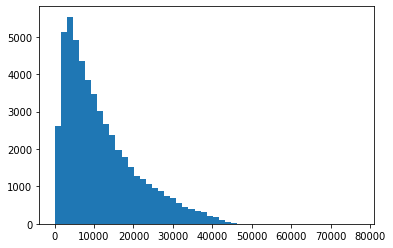

In [25]:
plt.hist(hourly_wind_de_df, bins = 50)

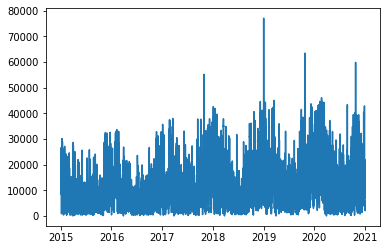

In [26]:
plt.plot(hourly_wind_de_df)

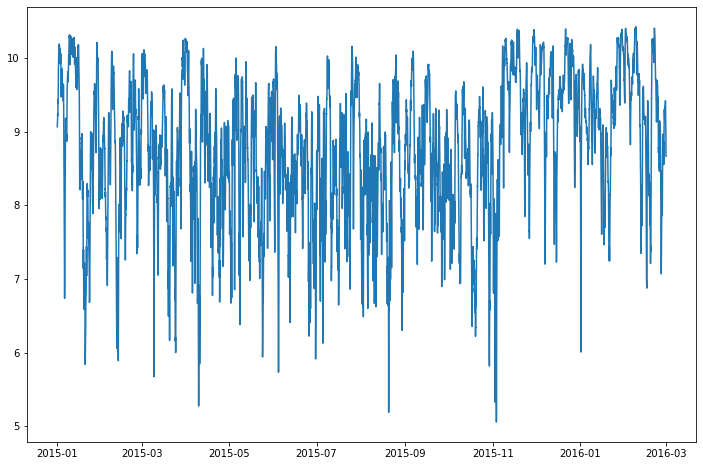

In [27]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.plot(np.log(hourly_wind_de_df.loc[:dt.date(2016,3,1)]))

{'whiskers': [<matplotlib.lines.Line2D at 0x13b22c880>,
 'caps': [<matplotlib.lines.Line2D at 0x13b22cee0>,
 'boxes': [<matplotlib.lines.Line2D at 0x13b22c430>],
 'medians': [<matplotlib.lines.Line2D at 0x13b237640>],
 'fliers': [<matplotlib.lines.Line2D at 0x13b2379d0>],
 'means': []}

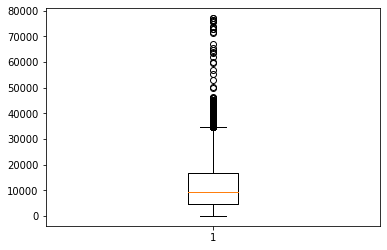

In [28]:
plt.boxplot(hourly_wind_de_df)

## Check for stationarity

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

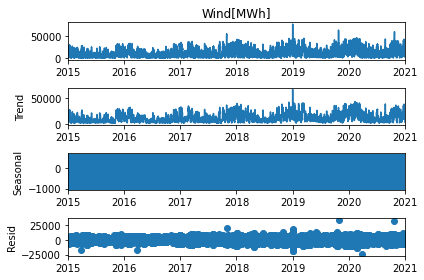

In [30]:
result_add = seasonal_decompose(hourly_wind_de_df['Wind[MWh]'], model='additive')
result_add.plot();

In [31]:
from statsmodels.tsa.stattools import adfuller

adfuller(hourly_wind_de_df['Wind[MWh]'])[1]

3.966579862447787e-29

In [32]:
print('additive resid: ', adfuller(result_add.resid.dropna())[1])

additive resid:  0.0


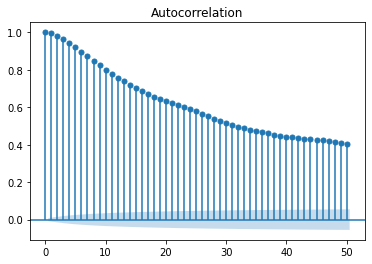

In [33]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(hourly_wind_de_df['Wind[MWh]'], lags=50)
plt.show()

In [34]:
y = hourly_wind_de_df['Wind[MWh]']

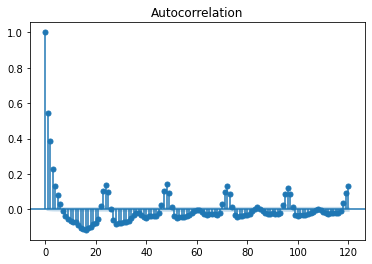

In [35]:
plot_acf(y.diff(1).dropna(), lags=120);

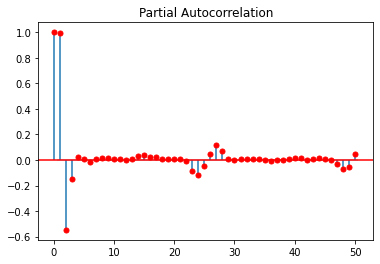

In [36]:
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(hourly_wind_de_df['Wind[MWh]'], lags=50, c='r')
plt.show()

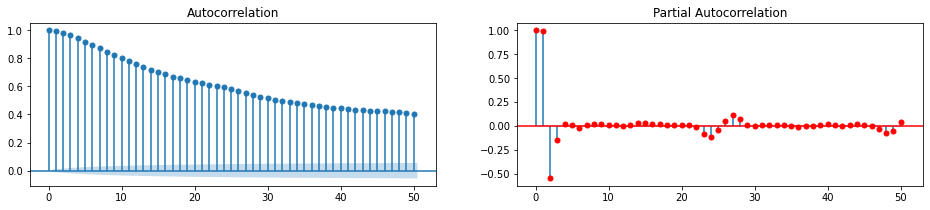

In [37]:
from statsmodels.graphics.tsaplots import plot_pacf
fig, axes = plt.subplots(1,2, figsize=(16,3))
plot_acf(hourly_wind_de_df['Wind[MWh]'], lags=50, ax=axes[0]);
plot_pacf(hourly_wind_de_df['Wind[MWh]'], lags=50, ax=axes[1], color='r');

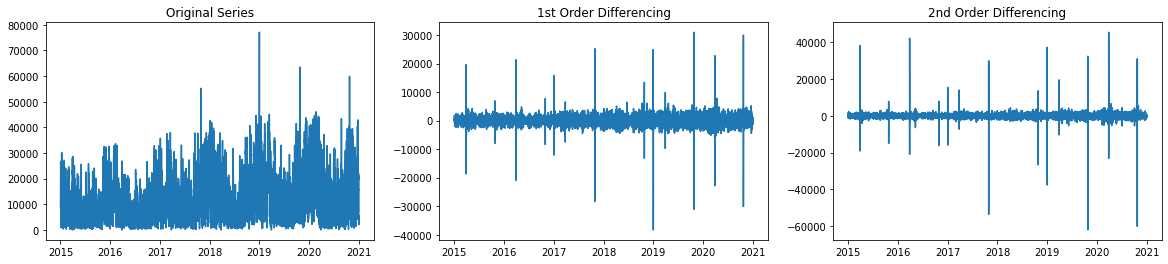

In [38]:
zero_diff = y
first_order_diff = y.diff(1)
second_order_diff = y.diff(1).diff(1)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
ax1.plot(zero_diff); ax1.set_title('Original Series')
ax2.plot(first_order_diff); ax2.set_title('1st Order Differencing')
ax3.plot(second_order_diff); ax3.set_title('2nd Order Differencing');

## Building train/ test split

In [39]:
hourly_windspeed_df.head()

,90,125,161,164,183,197,198,232,282,298,...,15000,15044,15120,15122,15189,15200,15207,15214,15444,1001
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,2.1,0.7,0.9,5.1,11.3,3.2,1.6,1.1,0.7,7.0,...,3.9,0.8,4.9,3.2,4.4,3.0,0.5,1.2,1.0,2.2
2015-01-01 01:00:00,2.7,0.3,0.8,4.9,13.0,3.2,2.6,1.5,0.9,7.4,...,3.4,0.7,5.3,2.6,6.0,2.8,0.8,1.1,1.0,2.5
2015-01-01 02:00:00,2.5,0.8,1.3,3.9,12.8,3.2,3.2,1.7,0.9,7.1,...,3.8,1.3,4.8,2.3,5.7,3.1,0.5,1.8,1.2,2.6
2015-01-01 03:00:00,2.0,0.7,1.4,3.7,12.4,3.2,3.5,1.5,0.6,6.9,...,4.2,1.1,4.2,2.5,5.4,3.2,0.7,1.1,1.0,2.8
2015-01-01 04:00:00,1.1,0.9,1.7,4.2,12.2,3.2,3.4,1.7,1.0,6.0,...,4.4,0.9,4.1,1.8,6.1,3.6,0.8,0.9,1.4,2.8


In [40]:
hourly_windspeed_df.tail()

,90,125,161,164,183,197,198,232,282,298,...,15000,15044,15120,15122,15189,15200,15207,15214,15444,1001
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-30 19:00:00,0.8,3.0,1.8,2.6,1.9,1.7,3.0,3.8,1.3,1.5,...,3.3,2.0,1.3,2.2,1.9,0.9,1.9,1.6,1.3,1.6
2021-04-30 20:00:00,0.9,1.9,1.3,2.2,2.7,0.6,2.5,2.9,1.3,2.1,...,2.5,2.1,1.8,3.2,1.5,1.0,1.5,1.3,1.1,2.0
2021-04-30 21:00:00,0.9,0.8,1.1,1.9,2.9,0.6,1.6,2.7,1.3,1.7,...,2.4,1.4,2.7,2.4,1.4,1.2,1.6,1.7,1.1,1.2
2021-04-30 22:00:00,0.7,0.7,3.1,1.7,1.1,0.7,1.3,2.6,1.3,2.4,...,2.0,3.8,3.0,2.8,1.3,1.1,0.9,1.1,0.9,1.7
2021-04-30 23:00:00,0.5,0.9,1.8,1.4,1.9,1.6,1.8,2.2,1.0,1.9,...,2.2,3.6,3.3,2.0,1.2,1.6,0.7,1.4,0.7,2.0


In [41]:
hourly_windspeed_df.shape

(55488, 260)

In [42]:
pd.DataFrame(y).tail()

,Wind[MWh]
Date,
2021-01-01 19:00:00,4845.0
2021-01-01 20:00:00,5028.0
2021-01-01 21:00:00,5204.0
2021-01-01 22:00:00,5681.0
2021-01-01 23:00:00,5333.0


In [107]:
y = pd.DataFrame(y)

In [108]:
X = hourly_windspeed_df[hourly_windspeed_df.index < dt.datetime(2021,1,2)]
X.tail()

,90,125,161,164,183,197,198,232,282,298,...,15000,15044,15120,15122,15189,15200,15207,15214,15444,1001
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01 19:00:00,0.8,3.0,1.1,2.3,6.1,2.0,1.6,0.8,0.7,2.7,...,3.1,1.0,2.8,0.7,2.5,2.4,0.7,1.6,1.3,1.0
2021-01-01 20:00:00,1.3,3.0,1.3,2.4,6.1,2.0,1.2,0.5,0.7,3.0,...,2.7,0.5,3.2,1.0,2.4,2.7,1.3,1.4,1.7,1.3
2021-01-01 21:00:00,1.5,3.4,0.8,2.5,6.4,3.0,1.6,1.0,0.7,2.5,...,2.8,0.7,4.2,0.9,2.2,3.5,0.7,1.7,1.6,1.0
2021-01-01 22:00:00,1.1,3.0,1.6,2.1,6.1,4.1,2.0,0.8,0.7,2.7,...,2.8,0.9,3.2,1.2,2.5,3.5,0.9,2.2,1.8,1.2
2021-01-01 23:00:00,0.9,3.0,1.3,2.7,5.9,4.2,2.1,1.1,0.5,1.9,...,2.9,0.7,3.1,1.3,2.3,3.5,1.1,1.2,1.9,0.9


In [109]:
X.shape

(52632, 260)

In [139]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100)

In [140]:
y_test.shape

(17369, 1)

In [141]:
X_test.shape

(17369, 260)

In [142]:
X_new_train, X_new_test, y_new_train, y_new_test = train_test_split(X_new, y, test_size=0.33, random_state=100)

# Correlation

In [50]:
df = y.merge(X, on = y.index)
df.set_index('key_0', inplace=True)
df.head()

,Wind[MWh],90,125,161,164,183,197,198,232,282,...,15000,15044,15120,15122,15189,15200,15207,15214,15444,1001
key_0,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,8646.0,2.1,0.7,0.9,5.1,11.3,3.2,1.6,1.1,0.7,...,3.9,0.8,4.9,3.2,4.4,3.0,0.5,1.2,1.0,2.2
2015-01-01 01:00:00,8816.0,2.7,0.3,0.8,4.9,13.0,3.2,2.6,1.5,0.9,...,3.4,0.7,5.3,2.6,6.0,2.8,0.8,1.1,1.0,2.5
2015-01-01 02:00:00,9058.0,2.5,0.8,1.3,3.9,12.8,3.2,3.2,1.7,0.9,...,3.8,1.3,4.8,2.3,5.7,3.1,0.5,1.8,1.2,2.6
2015-01-01 03:00:00,9071.0,2.0,0.7,1.4,3.7,12.4,3.2,3.5,1.5,0.6,...,4.2,1.1,4.2,2.5,5.4,3.2,0.7,1.1,1.0,2.8
2015-01-01 04:00:00,9168.0,1.1,0.9,1.7,4.2,12.2,3.2,3.4,1.7,1.0,...,4.4,0.9,4.1,1.8,6.1,3.6,0.8,0.9,1.4,2.8


In [51]:
df.corr()

,Wind[MWh],90,125,161,164,183,197,198,232,282,...,15000,15044,15120,15122,15189,15200,15207,15214,15444,1001
Wind[MWh],1.000000,0.672603,0.395687,0.422520,0.587090,0.554497,0.653802,0.624829,0.445144,0.448165,...,0.669465,0.409194,0.725409,0.580724,0.626353,0.679666,0.496731,0.234458,0.376230,0.596952
90,0.672603,1.000000,0.545460,0.615150,0.503244,0.344716,0.706512,0.705375,0.609000,0.660308,...,0.710404,0.537703,0.708801,0.727436,0.533143,0.693611,0.639233,0.321293,0.547412,0.610535
125,0.395687,0.545460,1.000000,0.415704,0.337991,0.183282,0.369076,0.464963,0.740716,0.530240,...,0.413296,0.388671,0.407869,0.652913,0.321170,0.334939,0.423857,0.480634,0.656638,0.444471
161,0.422520,0.615150,0.415704,1.000000,0.361246,0.175318,0.570896,0.566546,0.508336,0.609388,...,0.518157,0.820843,0.538246,0.555746,0.392953,0.485857,0.641223,0.274042,0.542759,0.450636
164,0.587090,0.503244,0.337991,0.361246,1.000000,0.608301,0.471145,0.586872,0.377648,0.470375,...,0.345453,0.310229,0.472740,0.449379,0.798180,0.338203,0.463984,0.164445,0.336485,0.763628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15200,0.679666,0.693611,0.334939,0.485857,0.338203,0.298603,0.680379,0.468729,0.392630,0.410845,...,0.822708,0.419182,0.733724,0.535383,0.408470,1.000000,0.432144,0.196923,0.340454,0.381428
15207,0.496731,0.639233,0.423857,0.641223,0.463984,0.239656,0.652784,0.632680,0.520095,0.644676,...,0.457868,0.630478,0.604143,0.576094,0.467799,0.432144,1.000000,0.263907,0.519029,0.570738
15214,0.234458,0.321293,0.480634,0.274042,0.164445,0.081304,0.230946,0.273079,0.444250,0.332115,...,0.259424,0.256689,0.224212,0.369386,0.143250,0.196923,0.263907,1.000000,0.400294,0.235138
15444,0.376230,0.547412,0.656638,0.542759,0.336485,0.160229,0.429123,0.525250,0.767483,0.654789,...,0.433212,0.464601,0.443427,0.668249,0.337448,0.340454,0.519029,0.400294,1.000000,0.442433


In [ ]:
import seaborn as sns

corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [149]:
corr_indices = corrMatrix['Wind[MWh]'][corrMatrix['Wind[MWh]']>0.7].index[1:]

In [150]:
corr_indices = list(corr_indices)
corr_indices

['342',
 '691',
 '701',
 '704',
 '722',
 '788',
 '963',
 '1270',
 '1358',
 '1503',
 '1612',
 '2014',
 '2483',
 '2856',
 '2932',
 '2961',
 '3987',
 '5480',
 '5715',
 '6091',
 '6108',
 '7396',
 '15120']

In [151]:
X_new = X[corr_indices]
X_new.head()

,342,691,701,704,722,788,963,1270,1358,1503,...,2856,2932,2961,3987,5480,5715,6091,6108,7396,15120
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,3.9,3.4,5.0,3.7,13.5,10.6,3.3,4.0,10.8,3.3,...,2.4,3.4,11.3,5.6,2.7,4.1,6.9,5.9,5.0,4.9
2015-01-01 01:00:00,3.2,2.6,5.6,3.5,14.7,10.8,3.6,4.1,8.4,4.0,...,2.4,3.1,10.9,5.5,2.5,4.0,6.9,5.1,4.5,5.3
2015-01-01 02:00:00,3.4,3.1,5.8,3.9,13.6,11.3,4.6,4.3,6.8,4.4,...,2.9,4.0,8.6,5.5,2.8,4.8,6.9,4.9,4.7,4.8
2015-01-01 03:00:00,3.5,3.6,6.2,3.9,13.0,11.6,3.8,3.7,7.0,4.7,...,3.0,4.3,10.0,6.1,2.9,5.0,6.9,5.6,4.5,4.2
2015-01-01 04:00:00,2.6,4.0,6.5,4.6,14.4,11.5,4.3,2.7,6.3,4.8,...,3.0,4.0,10.9,6.6,2.8,3.8,6.9,5.5,3.9,4.1


In [ ]:
X.head()

# Regression models

## Linear regression model

In [158]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

lr = LinearRegression()

cv_results = cross_validate(lr, X, y, cv=10, scoring=('r2', 'neg_mean_absolute_percentage_error'))

In [159]:
cv_results

{'fit_time': array([0.59632802, 0.49180913, 0.49020696, 0.49422288, 0.51933122,
        0.53489375, 0.54707789, 0.58526492, 0.55646896, 0.54808426]),
 'score_time': array([0.00810981, 0.00809288, 0.00890303, 0.00890923, 0.00910378,
        0.01030302, 0.00961924, 0.01066208, 0.00903606, 0.00916076]),
 'test_r2': array([0.48920585, 0.80760904, 0.79668375, 0.90958285, 0.93401217,
        0.90931285, 0.86390644, 0.8769665 , 0.8773749 , 0.88747647]),
 'test_neg_mean_absolute_percentage_error': array([-2.13159782e+16, -4.76243585e-01, -2.00446471e+16, -5.58119545e+15,
        -3.66706707e-01, -4.18453689e+15, -2.44137948e-01, -7.38374121e+15,
        -1.51884748e+16, -3.06504286e-01])}

In [92]:
X_train.head()

,6091,1358
Date,,
2015-05-01 03:00:00,9.0,9.0
2018-03-05 12:00:00,7.8,2.8
2015-03-05 02:00:00,8.7,13.6
2018-09-28 14:00:00,12.1,5.7
2017-02-21 07:00:00,9.6,16.7


In [160]:
reg = LinearRegression().fit(X_train, y_train)

reg.score(X_train, y_train)

0.9090575803339822

In [155]:
reg.predict(X_test)

array([[7898.71956477],
       [3495.55074195],
       [-409.18556633],
       ...,
       [6651.49842327],
       [-252.63646404],
       [4481.64665429]])

In [156]:
y_test[y_test['Wind[MWh]']==0]

,Wind[MWh]
Date,
2017-03-26 02:00:00,0.0
2018-03-25 02:00:00,0.0
2019-03-31 02:00:00,0.0


In [157]:
mean_absolute_percentage_error(y_test,reg.predict(X_test))

<ipython-input-60-f24ea0061afc>:13: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


inf

## Define loss functions

In [176]:
y_test[y_test['Wind[MWh]']==0].index

DatetimeIndex(['2017-03-26 02:00:00', '2018-03-25 02:00:00',
               '2019-03-31 02:00:00'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [169]:
np.array(y_test)[y_test==0]

array([0., 0., 0.])

In [60]:
def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(np.abs(y_true-y_pred))/(len(y_true))

def mse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true-y_pred)**2)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## XGboost

In [61]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

In [62]:
data_dmatrix = xgb.DMatrix(data=X_new,label=y)

In [63]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

In [64]:
xg_reg.fit(X_new_train,y_new_train)

preds = xg_reg.predict(X_new_test)

In [65]:
pd.DataFrame(preds)

,0
0,2907.375977
1,5497.053223
2,4673.609375
3,6867.711426
4,14256.206055
...,...
17364,3714.917725
17365,17646.210938
17366,1866.590210
17367,5537.935059


In [66]:
y_test

,Wind[MWh]
Date,
2016-10-22 14:00:00,2848.0
2017-03-06 05:00:00,10012.0
2017-02-03 13:00:00,4567.0
2015-06-05 12:00:00,4171.0
2020-03-15 05:00:00,30692.0
...,...
2018-08-31 19:00:00,4702.0
2015-01-29 02:00:00,21183.0
2015-06-30 19:00:00,1689.0


In [67]:
rmse = np.sqrt(mean_squared_error(y_new_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 6271.780005


In [68]:
params = {"objective":"reg:squarederror",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [69]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,13638.032227,31.381905,13642.510742,74.077763
1,12418.469076,27.849412,12425.596028,76.919199
2,11329.879557,23.246196,11341.708008,79.903555
3,10357.671875,27.781977,10373.591797,74.499627
4,9487.891276,19.019408,9508.214193,80.424655


In [70]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

ExecutableNotFound: failed to execute ['dot', '-Kdot', '-Tpng'], make sure the Graphviz executables are on your systems' PATH

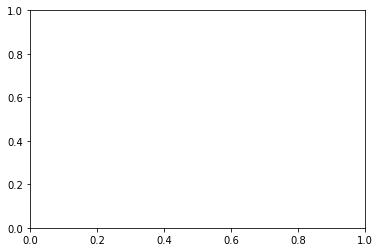

In [71]:
import matplotlib.pyplot as plt

xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

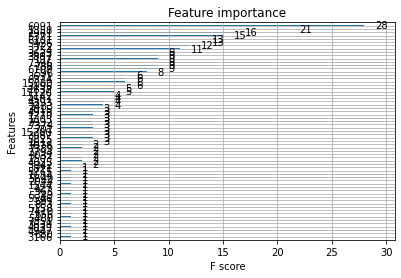

In [74]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [160, 16]
plt.show()

In [75]:
mean_absolute_percentage_error(y_new_test,preds)

118.37363705482093

In [76]:
X.loc[:, ['6091', '1358']]

,6091,1358
Date,,
2015-01-01 00:00:00,6.9,10.8
2015-01-01 01:00:00,6.9,8.4
2015-01-01 02:00:00,6.9,6.8
2015-01-01 03:00:00,6.9,7.0
2015-01-01 04:00:00,6.9,6.3
...,...,...
2021-01-01 19:00:00,5.2,5.7
2021-01-01 20:00:00,5.3,4.4
2021-01-01 21:00:00,6.2,1.9


In [90]:
X_train, X_test, y_train, y_test = train_test_split(X.loc[:, ['6091', '1358']], y, test_size=0.33, random_state=42)

In [78]:
X_train.shape

(35263, 2)

In [79]:
y_train.shape

(35263, 1)

In [80]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

AttributeError: 'Booster' object has no attribute 'fit'

In [ ]:
mean_absolute_percentage_error(y_test,preds)